### Stock Prices and Google Trends Heatmap Analysis
### This notebook creates visualizations for stock price movements and Google search trends data.
### Required Data Files:
#### - `prices.csv`: Stock/ETF daily closing prices (columns = stocks, rows = dates)
#### - `trends.csv`: Google search trends data (columns = search terms, rows = dates)

In [10]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


### Helper Functions

In [4]:
def load_and_process_data(filepath, data_type='prices'):
    """
    Load CSV data and process it for heatmap visualization
    """
    try:
        # Load the data
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        print(f"Loaded {data_type} data: {df.shape[0]} dates, {df.shape[1]} columns")

        # Handle any missing values
        if df.isnull().sum().sum() > 0:
            print(f"Warning: Found {df.isnull().sum().sum()} missing values in {data_type} data")
            df = df.fillna(method='ffill').fillna(method='bfill')

        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

In [5]:
def normalize_prices(df_prices):
    """
    Normalize prices to percentage change from first value for better visualization
    """
    # Calculate percentage change from first valid value for each stock
    df_normalized = pd.DataFrame(index=df_prices.index, columns=df_prices.columns)

    for col in df_prices.columns:
        first_valid = df_prices[col].first_valid_index()
        if first_valid is not None:
            first_value = df_prices.loc[first_valid, col]
            if first_value != 0:
                df_normalized[col] = ((df_prices[col] / first_value) - 1) * 100
            else:
                df_normalized[col] = 0

    return df_normalized

In [8]:
def create_heatmap(data, title, ax, cmap='RdYlGn', center=None, fmt='.1f',
                    vmin=None, vmax=None, cbar_label='Value'):
    """
    Create a heatmap with customizable parameters
    """
    # Transpose data so columns (stocks/trends) are on y-axis and dates on x-axis
    data_transposed = data.T

    # Create the heatmap
    sns.heatmap(data_transposed,
                cmap=cmap,
                center=center,
                ax=ax,
                cbar_kws={'label': cbar_label},
                xticklabels=False,  # We'll customize x-labels
                yticklabels=True,
                vmin=vmin,
                vmax=vmax)

    # Set title
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Customize x-axis to show dates at regular intervals
    n_dates = len(data.index)
    if n_dates > 20:
        # Show approximately 10 date labels
        step = n_dates // 10
        positions = range(0, n_dates, step)
        labels = [data.index[i].strftime('%Y-%m-%d') if hasattr(data.index[i], 'strftime')
                    else str(data.index[i]) for i in positions]
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45, ha='right')
    else:
        # Show all dates if not too many
        labels = [date.strftime('%Y-%m-%d') if hasattr(date, 'strftime')
                    else str(date) for date in data.index]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Stocks/Trends', fontsize=12)

    # Adjust y-axis labels if too many
    if len(data.columns) > 30:
        # Show every nth label
        n = max(1, len(data.columns) // 30)
        for i, label in enumerate(ax.yaxis.get_ticklabels()):
            if i % n != 0:
                label.set_visible(False)

### Load and Explore Data

In [12]:
DATA_ROOT = Path("../../data")

PROCESSED_DATA = DATA_ROOT / "processed"

# File paths
prices_file = PROCESSED_DATA / 'prices.csv'
trends_file = PROCESSED_DATA / 'trends.csv'

In [26]:
PLOT_ROOT = Path("../../plots/heatmaps")
PLOT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Plot directory set to: {PLOT_ROOT}")

Plot directory set to: ../../plots/heatmaps


In [13]:
print("Loading data files...")
print("-" * 50)

df_prices = load_and_process_data(prices_file, 'prices')
df_trends = load_and_process_data(trends_file, 'trends')

Loading data files...
--------------------------------------------------
Loaded prices data: 1796 dates, 75 columns
Loaded trends data: 1796 dates, 1792 columns


In [14]:
# Display basic information about the data
if df_prices is not None:
    print("\nPRICES DATA SUMMARY:")
    print("-" * 30)
    print(f"Date range: {df_prices.index[0]} to {df_prices.index[-1]}")
    print(f"Number of stocks/ETFs: {len(df_prices.columns)}")
    print(f"Sample stocks: {list(df_prices.columns[:5])}")
    print("\nFirst few rows:")
    display(df_prices.head())

    print("\nBasic statistics:")
    display(df_prices.describe())


PRICES DATA SUMMARY:
------------------------------
Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00
Number of stocks/ETFs: 75
Sample stocks: ['ISRG', 'IYT', 'IWM', 'IBB', 'GOOGL']

First few rows:


ISRG        IYT         IWM         IBB      GOOGL  \
date                                                                   
2020-08-27  236.463333  46.925476  146.403839  131.002609  80.940575   
2020-08-28  242.336670  47.483498  147.644226  131.377853  81.482826   
2020-08-29  244.081193  47.329887  147.138932  133.376632  81.420886   
2020-08-30  243.804285  46.955746  146.179162  134.911696  81.131341   
2020-08-31  243.613327  46.852177  146.056122  133.895798  80.990776   

                     V        XLP         XLY        BAC       ISRA  ...  \
date                                                                 ...   
2020-08-27  203.611053  57.195606  143.615967  23.030514  35.089546  ...   
2020-08-28  208.126556  57.704460  144.557129  23.251541  35.362797  ...   
2020-08-29  208.198420  57.882851  144.472875  23.191733  35.525316  ...   
2020-08-30  206.208175  57.803161  144.089818  22.982799  35.538263  ...   
2020-08-31  204.537354  57.537773  144.134567  22.756449  35.362797  ...   

                  NVO         MS         UNH          MA        SLB  \
date                                                                  
2020-08-27  30.759895  44.791851  288.800781  346.114990  16.851892   
2020-08-28  30.560276  45.030251  291.302490  355.954010  17.500734   
2020-08-29  30.583820  44.894657  292.013952  357.217653  17.638636   
2020-08-30  30.669868  44.633166  291.322671  353.462275  17.453007   
2020-08-31  30.657763  44.493870  289.616150  348.244232  17.131258   

                   SAP        ASML         JNJ         CRM         BLK  
date                                                                    
2020-08-27  152.611481  361.628723  132.644745  273.919769  526.954834  
2020-08-28  153.412018  364.752655  133.216965  268.745148  532.339844  
2020-08-29  153.311907  361.493329  134.078531  264.944506  532.610760  
2020-08-30  152.760361  357.811489  134.316408  264.721974  529.878832  
2020-08-31  152.206589  359.667877  133.017563  270.281677  526.255310  

[5 rows x 75 columns]


Basic statistics:


ISRG          IYT          IWM          IBB        GOOGL  \
count  1796.000000  1796.000000  1796.000000  1796.000000  1796.000000   
mean    339.933124    60.413333   193.715479   136.098526   131.368462   
std     107.398894     6.338767    21.282741    13.800291    30.828386   
min     181.670986    45.839290   135.897263   104.920464    69.998380   
25%     256.402512    55.285772   177.082034   126.568695   106.287148   
50%     307.801165    61.031368   195.578751   133.717606   131.764275   
75%     397.498448    65.112691   211.024715   145.164500   153.929337   
max     610.450012    74.791793   241.169908   174.496554   205.893341   

                 V          XLP          XLY          BAC         ISRA  ...  \
count  1796.000000  1796.000000  1796.000000  1796.000000  1796.000000  ...   
mean    242.118194    69.432409   171.551017    34.697068    39.388278  ...   
std      47.547353     6.880780    24.917024     6.583710     5.104261  ...   
min     172.801687    54.816882   123.540680    20.707155    26.881922  ...   
25%     206.675987    64.570373   151.632611    29.546639    35.124014  ...   
50%     225.027835    69.084721   170.416367    34.473957    38.136765  ...   
75%     270.216270    73.786655   183.669807    39.492505    43.882273  ...   
max     372.654297    83.299866   237.815460    49.644308    53.414047  ...   

               NVO           MS          UNH           MA          SLB  \
count  1796.000000  1796.000000  1796.000000  1796.000000  1796.000000   
mean     71.269586    86.067863   450.749962   398.908793    38.378476   
std      31.167149    21.363993    80.011905    77.248411    10.802916   
min      29.416671    39.521729   271.819244   277.589970    12.814095   
25%      48.122068    74.948795   390.431747   342.153198    30.355632   
50%      65.553905    82.293774   472.704184   368.433411    39.570976   
75%      92.505566    91.932775   505.415405   453.000496    46.876770   
max     144.041077   144.825319   619.751137   589.941772    59.365982   

               SAP         ASML          JNJ          CRM          BLK  
count  1796.000000  1796.000000  1796.000000  1796.000000  1796.000000  
mean    154.619889   667.624675   149.166326   234.082330   744.641568  
std      59.697712   153.203630     8.825167    49.745604   140.608053  
min      76.156751   329.786334   118.884285   127.155785   476.723053  
25%     113.559466   574.377014   143.890465   202.716194   637.162316  
50%     132.095299   665.105356   149.886179   237.315327   725.552979  
75%     187.630634   749.920543   154.683058   267.553116   828.086085  
max     311.929993  1089.305176   168.324478   366.293427  1139.707430  

[8 rows x 75 columns]

In [15]:
if df_trends is not None:
    print("\nTRENDS DATA SUMMARY:")
    print("-" * 30)
    print(f"Date range: {df_trends.index[0]} to {df_trends.index[-1]}")
    print(f"Number of search terms: {len(df_trends.columns)}")
    print(f"Sample search terms: {list(df_trends.columns[:5])}")
    print("\nFirst few rows:")
    display(df_trends.head())

    print("\nBasic statistics:")
    display(df_trends.describe())


TRENDS DATA SUMMARY:
------------------------------
Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00
Number of search terms: 1792
Sample search terms: ['fintech trends', 'Ethiopia', 'Airbnb news', 'renewable energy stocks', 'Dyson Vacuum vs competitor']

First few rows:


fintech trends   Ethiopia  Airbnb news  renewable energy stocks  \
date                                                                          
2020-08-27        8.987430  49.792839    28.035593                13.987242   
2020-08-28        9.458953  50.203574    27.576210                13.318365   
2020-08-29        9.814172  50.619298    27.230798                12.645560   
2020-08-30       10.000000  51.000000    27.000000                12.000000   
2020-08-31        9.983473  51.313472    26.879654                11.410345   

            Dyson Vacuum vs competitor  SolarEdge news  Eli Lilly stock price  \
date                                                                            
2020-08-27               -7.601269e-57       15.212578               8.931825   
2020-08-28               -7.297219e-57       15.339585               8.673327   
2020-08-29               -4.956028e-57       14.958356               8.356366   
2020-08-30                0.000000e+00       14.000000               8.000000   
2020-08-31                7.692485e-57       12.438352               7.626194   

            war in Syria  Atlassian  cancel culture  ...  Xiaomi layoffs  \
date                                                 ...                   
2020-08-27      7.933649  46.312034       32.074218  ...    2.706003e-62   
2020-08-28      7.937936  46.830981       29.015739  ...    2.597762e-62   
2020-08-29      7.958698  47.098303       26.224635  ...    1.764314e-62   
2020-08-30      8.000000  47.000000       24.000000  ...    0.000000e+00   
2020-08-31      8.065305  46.464350       22.563924  ...   -2.738475e-62   

            probiotics  Lululemon earnings report  Benjamin Netanyahu  \
date                                                                    
2020-08-27   59.262065               1.585519e-24            3.041319   
2020-08-28   59.245868               1.522098e-24            3.058441   
2020-08-29   59.164009               1.033758e-24            3.049470   
2020-08-30   59.000000               0.000000e+00            3.000000   
2020-08-31   58.748528              -1.604545e-24            2.903468   

            youth climate movement  Mitch McConnell on green bonds  \
date                                                                 
2020-08-27            4.881737e-15                  -1.941721e-133   
2020-08-28            4.686468e-15                  -1.864052e-133   
2020-08-29            3.182893e-15                  -1.266002e-133   
2020-08-30            0.000000e+00                    0.000000e+00   
2020-08-31           -4.940318e-15                   1.965021e-133   

            Meta Quest 3 sales in Jerusalem  Teva Pharmaceutical news  \
date                                                                    
2020-08-27                    -1.029779e-79                 -0.004956   
2020-08-28                    -9.885879e-80                 -0.004758   
2020-08-29                    -6.714159e-80                 -0.003231   
2020-08-30                     0.000000e+00                  0.000000   
2020-08-31                     1.042136e-79                  0.005015   

            Apple response to NATO  air quality controversy  
date                                                         
2020-08-27           -1.253779e-86             3.396952e-52  
2020-08-28           -1.203628e-86             3.261074e-52  
2020-08-29           -8.174639e-87             2.214813e-52  
2020-08-30            0.000000e+00             0.000000e+00  
2020-08-31            1.268824e-86            -3.437715e-52  

[5 rows x 1792 columns]


Basic statistics:


fintech trends     Ethiopia  Airbnb news  renewable energy stocks  \
count     1796.000000  1796.000000  1796.000000              1796.000000   
mean        13.359474    63.310351    25.075122                18.847766   
std         11.329896     7.028944     6.087942                13.299703   
min         -3.459451    48.000000    13.000000                 4.953967   
25%          9.403561    59.131090    21.207117                10.155079   
50%         11.570880    62.390800    24.810566                15.391974   
75%         14.273936    65.848596    27.292661                22.786314   
max        100.000000   103.007645   100.000000               100.000000   

       Dyson Vacuum vs competitor  SolarEdge news  Eli Lilly stock price  \
count                1.796000e+03     1796.000000            1796.000000   
mean                 7.327394e-01        5.016288              30.557558   
std                  7.743245e+00        8.438813              22.393198   
min                 -1.350984e+01       -7.765667               4.473004   
25%                 -1.993092e-20       -0.003452              11.966882   
50%                  0.000000e+00        0.575728              18.929888   
75%                  7.506351e-20        9.328972              50.176603   
max                  1.000000e+02      100.000000             100.000000   

       war in Syria    Atlassian  cancel culture  ...  Xiaomi layoffs  \
count   1796.000000  1796.000000     1796.000000  ...    1.796000e+03   
mean      11.048058    48.237894       13.187242  ...    4.939017e-01   
std        7.778194    13.544098       11.299014  ...    4.825256e+00   
min        3.928631    16.653632        2.910612  ...   -6.792431e+00   
25%        7.813498    35.723985        6.214161  ...   -7.897205e-28   
50%        9.699807    49.871571       10.380704  ...    0.000000e+00   
75%       11.388055    56.520703       15.777303  ...    7.624289e-27   
max      100.699249   100.000000      102.498558  ...    1.000000e+02   

        probiotics  Lululemon earnings report  Benjamin Netanyahu  \
count  1796.000000               1.796000e+03         1796.000000   
mean     69.475382               5.279144e-01           10.738192   
std      10.426988               5.128431e+00           15.017830   
min      48.578709              -6.484721e+00           -3.869274   
25%      61.768960              -5.581866e-17            2.017026   
50%      68.164407               0.000000e+00            4.033452   
75%      75.585972               6.187680e-16           13.000000   
max     100.310723               1.000000e+02          102.718902   

       youth climate movement  Mitch McConnell on green bonds  \
count            1.796000e+03                    1.796000e+03   
mean             6.742762e-01                    7.249443e-01   
std              7.197682e+00                    7.768265e+00   
min             -1.350984e+01                   -2.335777e+01   
25%             -1.312036e-22                   -2.858895e-73   
50%              0.000000e+00                    0.000000e+00   
75%              9.632820e-22                    2.990884e-71   
max              1.000000e+02                    1.000000e+02   

       Meta Quest 3 sales in Jerusalem  Teva Pharmaceutical news  \
count                     1.796000e+03              1.796000e+03   
mean                      7.405345e-01              1.157047e+00   
std                       7.820490e+00              9.945461e+00   
min                      -1.350984e+01             -1.351097e+01   
25%                      -1.635221e-34             -2.387960e-21   
50%                       0.000000e+00              0.000000e+00   
75%                       2.122598e-33              7.644361e-20   
max                       1.000000e+02              1.000000e+02   

       Apple response to NATO  air quality controversy  
count            1.796000e+03             1.796000e+03  
mean             7.035271e-01             2.

### Data Preprocessing

In [16]:
if df_prices is not None:
    print("Normalizing price data...")
    df_prices_normalized = normalize_prices(df_prices)

    print("Normalization complete!")
    print("\nNormalized prices (% change from initial value):")
    display(df_prices_normalized.head())

    # Show distribution of changes
    all_changes = df_prices_normalized.values.flatten()
    all_changes = all_changes[~np.isnan(all_changes)]

    print(f"\nDistribution of price changes:")
    print(f"  Min change: {all_changes.min():.2f}%")
    print(f"  Max change: {all_changes.max():.2f}%")
    print(f"  Mean change: {all_changes.mean():.2f}%")
    print(f"  Median change: {np.median(all_changes):.2f}%")

Normalizing price data...
Normalization complete!

Normalized prices (% change from initial value):


ISRG       IYT       IWM       IBB     GOOGL         V  \
date                                                                     
2020-08-27  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-28  2.483826  1.189165  0.847237  0.286440  0.669938  2.217710   
2020-08-29  3.221582  0.861815  0.502099  1.812195  0.593413  2.253004   
2020-08-30  3.104478  0.064506 -0.153464  2.983976  0.235687  1.275531   
2020-08-31  3.023722 -0.156204 -0.237506  2.208497  0.062023  0.454936   

                 XLP       XLY       BAC      ISRA  ...       NVO        MS  \
date                                                ...                       
2020-08-27  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-28  0.889673  0.655333  0.959715  0.778724  ... -0.648960  0.532239   
2020-08-29  1.201569  0.596667  0.700025  1.241880  ... -0.572419  0.229520   
2020-08-30  1.062241  0.329943 -0.207179  1.278777  ... -0.292677 -0.354272   
2020-08-31  0.598240  0.361102 -1.190008  0.778724  ... -0.332032 -0.665258   

                 UNH        MA       SLB       SAP      ASML       JNJ  \
date                                                                     
2020-08-27  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-28  0.866240  2.842703  3.850261  0.524559  0.863851  0.431393   
2020-08-29  1.112591  3.207796  4.668575  0.458961 -0.037440  1.080922   
2020-08-30  0.873228  2.122787  3.567044  0.097555 -1.055567  1.260256   
2020-08-31  0.282329  0.615183  1.657770 -0.265309 -0.542226  0.281065   

                 CRM       BLK  
date                            
2020-08-27  0.000000  0.000000  
2020-08-28 -1.889101  1.021911  
2020-08-29 -3.276603  1.073323  
2020-08-30 -3.357843  0.554886  
2020-08-31 -1.328160 -0.132748  

[5 rows x 75 columns]


Distribution of price changes:
  Min change: -75.63%
  Max change: 1303.40%
  Mean change: 54.49%
  Median change: 32.42%


### Create Main Heatmaps

Creating prices heatmap...
Creating trends heatmap...

Heatmap saved as '../../plots/heatmaps/stock_trends_heatmap.png'


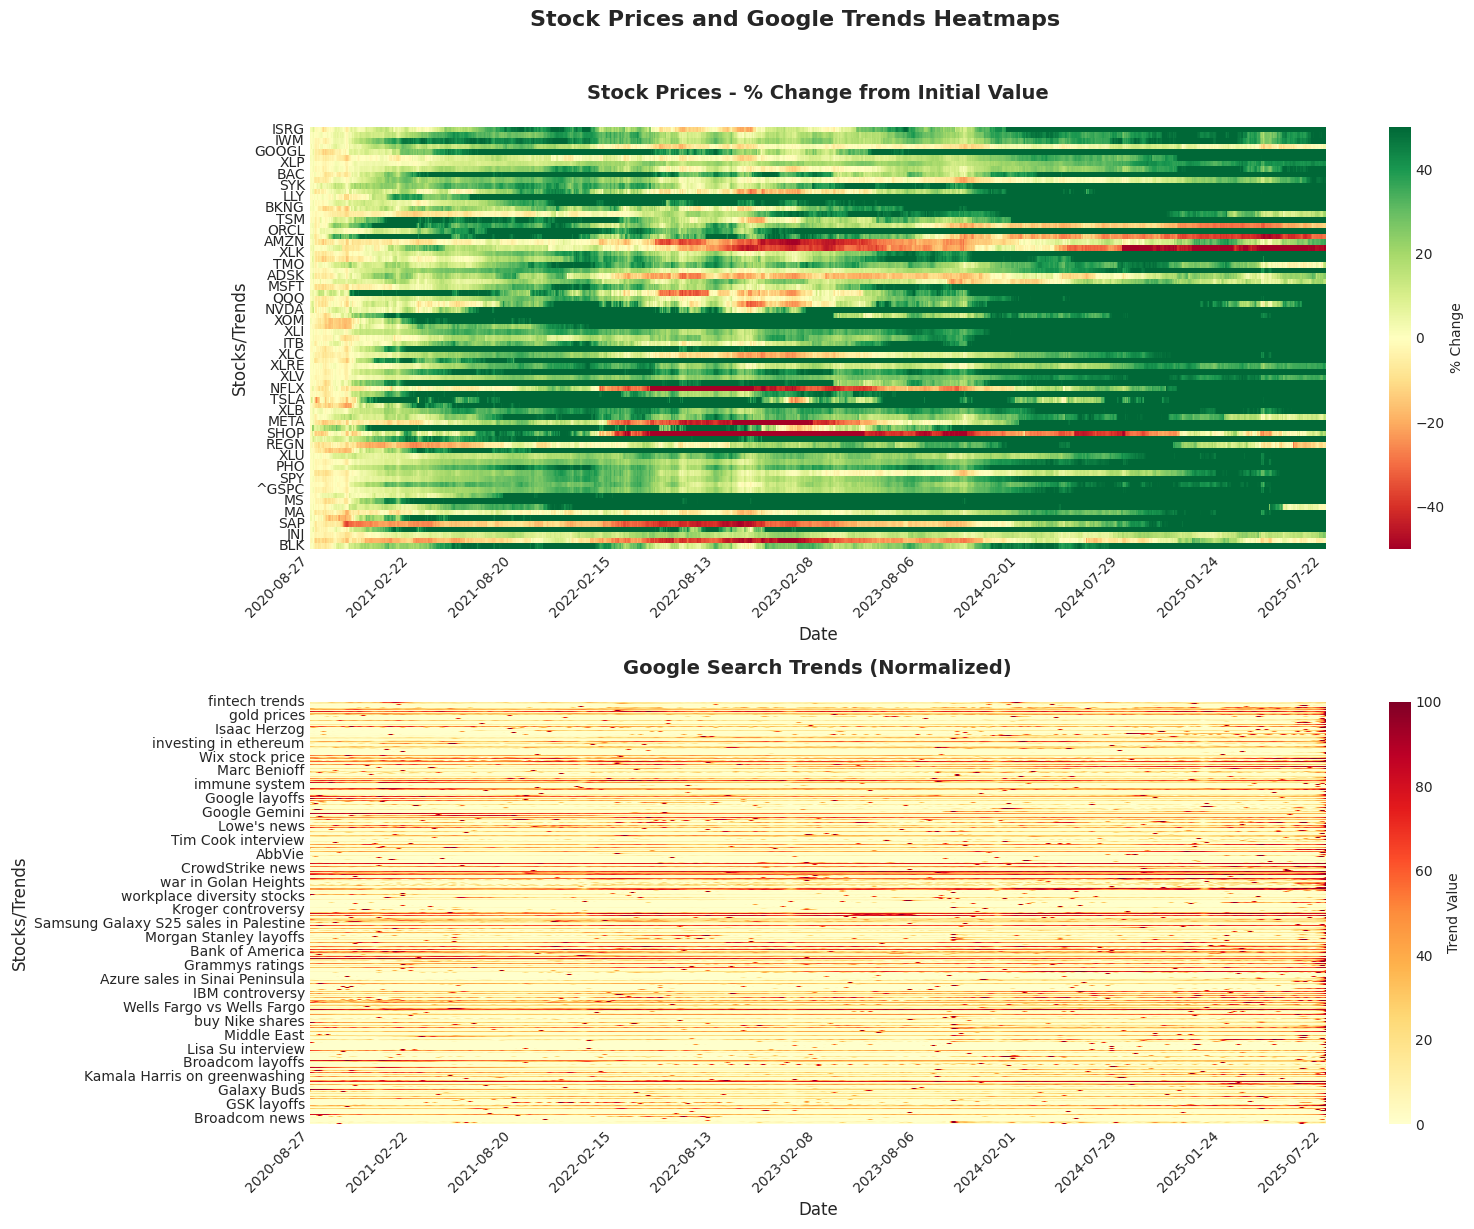

In [27]:
if df_prices is not None and df_trends is not None:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle('Stock Prices and Google Trends Heatmaps',
                fontsize=16, fontweight='bold', y=1.02)

    # Create prices heatmap
    print("Creating prices heatmap...")
    create_heatmap(df_prices_normalized,
                    'Stock Prices - % Change from Initial Value',
                    axes[0],
                    cmap='RdYlGn',
                    center=0,
                    vmin=-50,  # Adjust based on your data range
                    vmax=50,
                    cbar_label='% Change')

    # Create trends heatmap
    print("Creating trends heatmap...")
    create_heatmap(df_trends,
                'Google Search Trends (Normalized)',
                axes[1],
                cmap='YlOrRd',
                center=None,
                vmin=0,
                vmax=100,
                cbar_label='Trend Value')

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    output_file = 'stock_trends_heatmap.png'
    plt.savefig((PLOT_ROOT / output_file), dpi=300, bbox_inches='tight')
    print(f"\nHeatmap saved as '{(PLOT_ROOT / output_file)}'")

    # Show the plot
    plt.show()
else:
    print("Error: Could not create heatmaps. Please check that both data files are loaded correctly.")

### Individual Heatmaps with Custom Settings

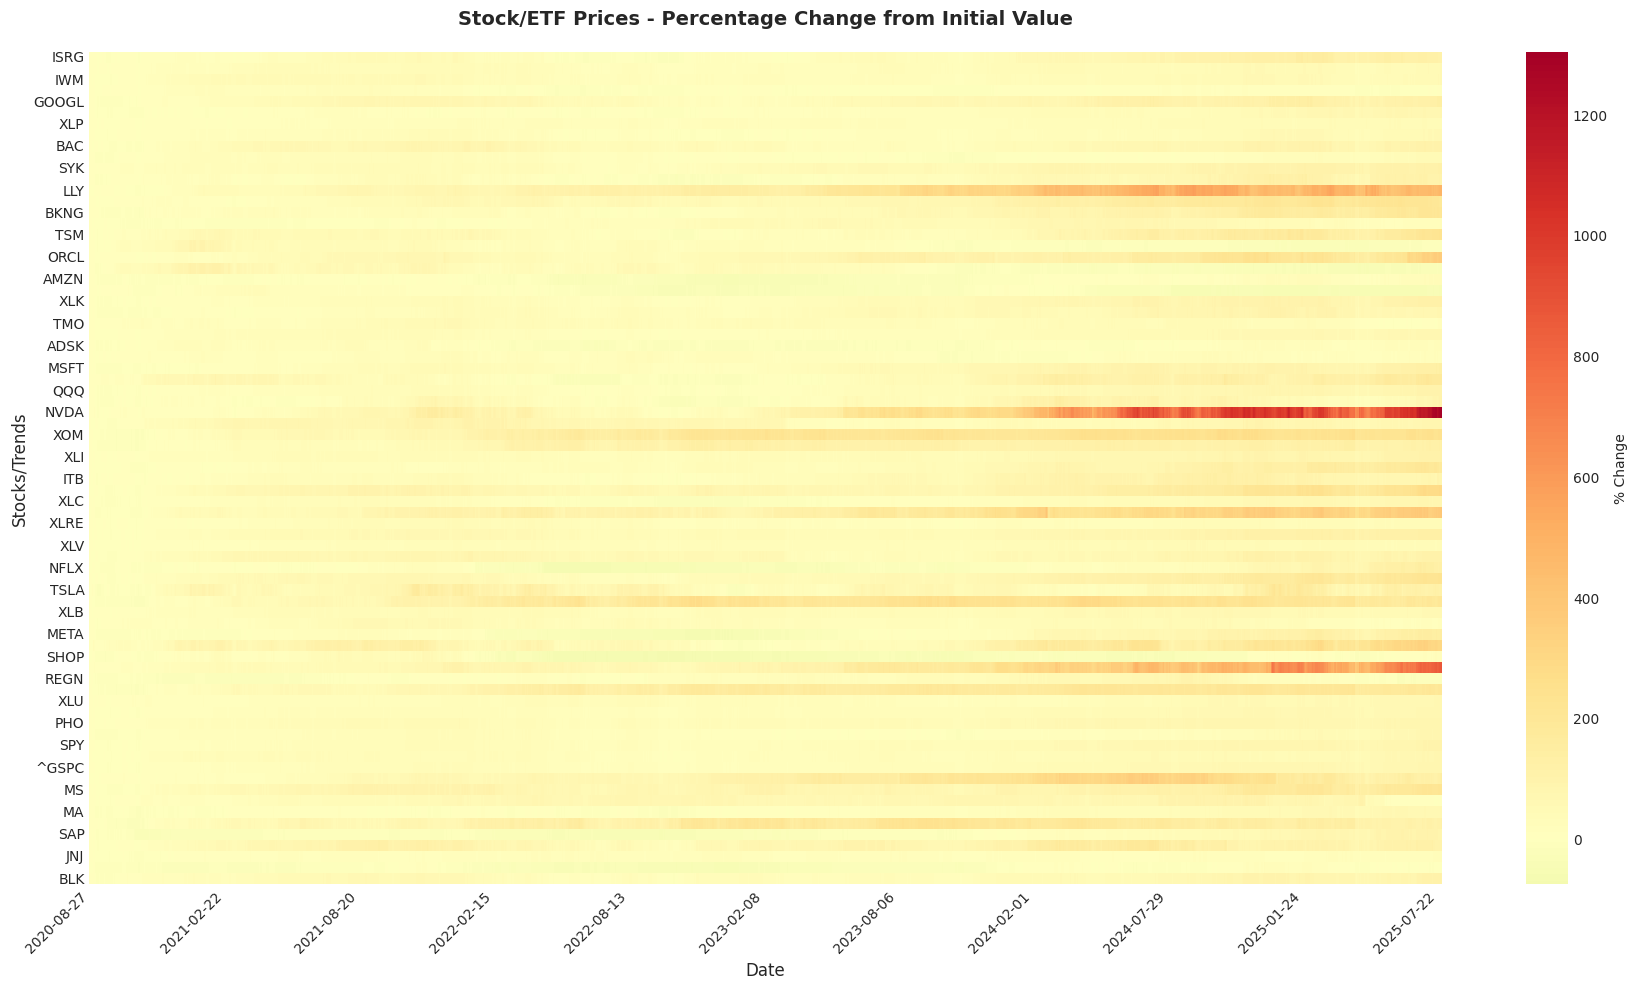

In [29]:
# Create a larger, more detailed prices heatmap
if df_prices_normalized is not None:
    fig, ax = plt.subplots(figsize=(18, 10))

    # You can customize the colormap here
    create_heatmap(df_prices_normalized,
                    'Stock/ETF Prices - Percentage Change from Initial Value',
                    ax,
                    cmap='RdYlGn_r',  # Try different colormaps: 'coolwarm', 'RdBu_r', 'seismic'
                    center=0,
                    vmin=df_prices_normalized.min().min(),
                    vmax=df_prices_normalized.max().max(),
                    cbar_label='% Change')

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'detailed_prices_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

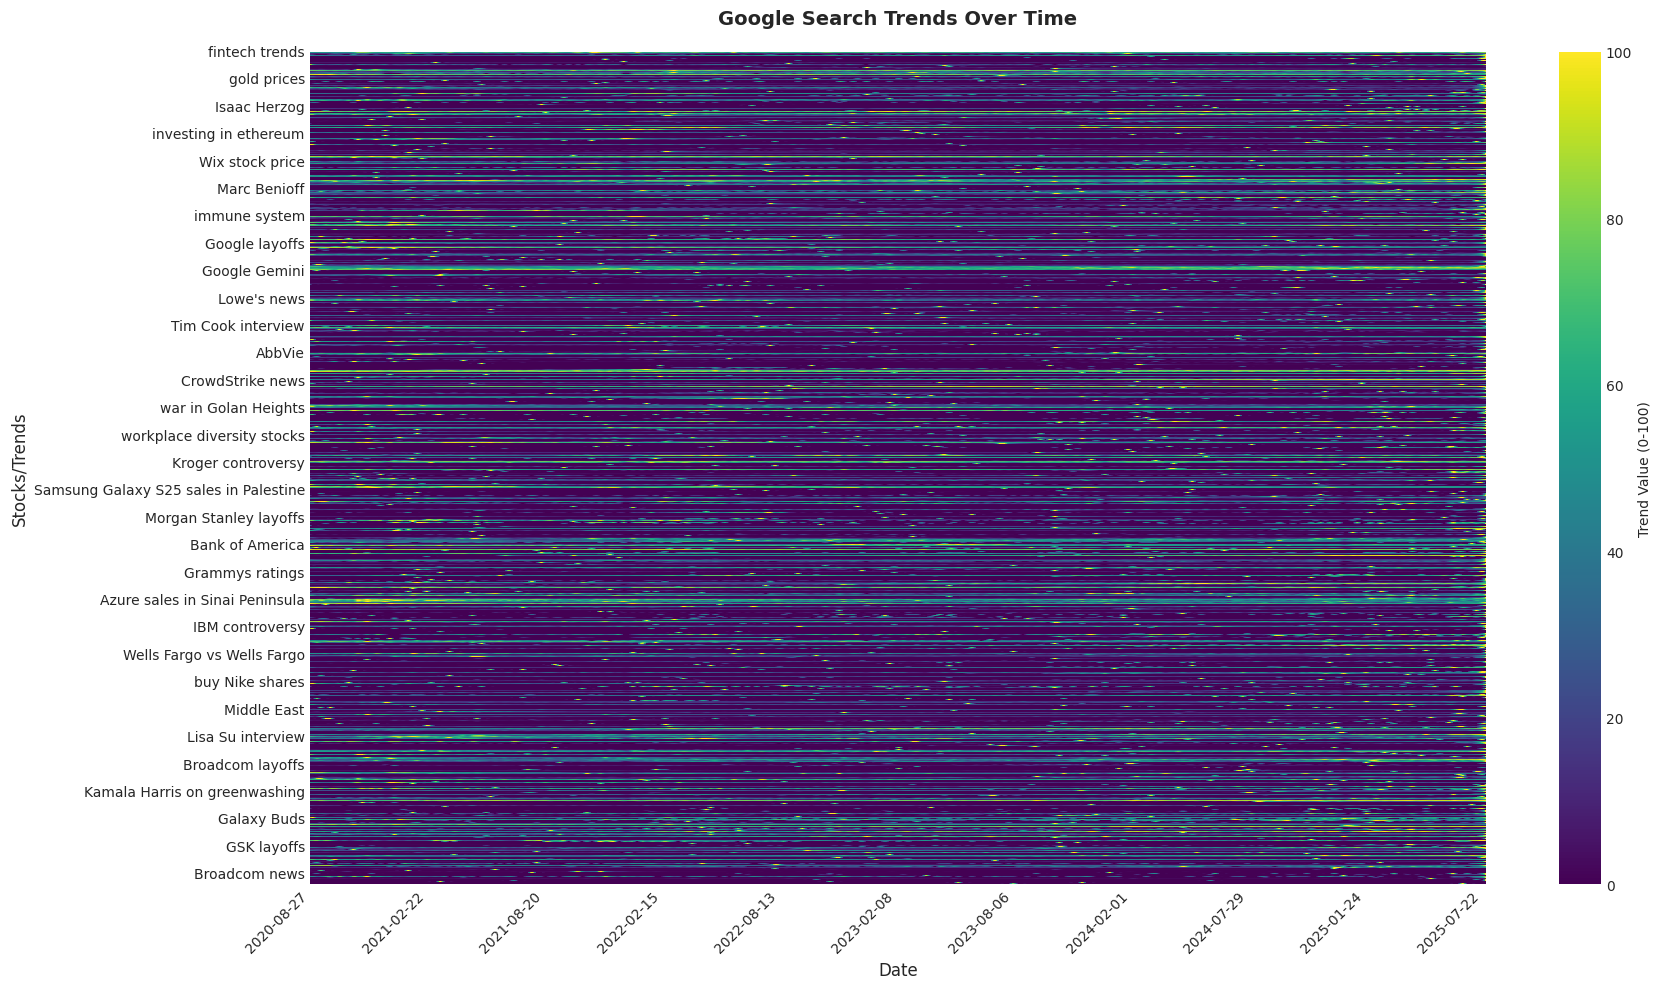

In [30]:
### # Create a larger, more detailed trends heatmap
if df_trends is not None:
    fig, ax = plt.subplots(figsize=(18, 10))

    # You can customize the colormap here
    create_heatmap(df_trends,
                    'Google Search Trends Over Time',
                    ax,
                    cmap='viridis',  # Try different colormaps: 'plasma', 'inferno', 'magma'
                    center=None,
                    vmin=0,
                    vmax=100,
                    cbar_label='Trend Value (0-100)')

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'detailed_trends_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

### Correlation Analysis

In [50]:
def correlations(df_prices, df_trends, sample_size_prices, sample_size_trends, annotation_limit=400):
    common_dates = df_prices.index.intersection(df_trends.index)
    print(f"Found {len(common_dates)} common dates between datasets")

    if len(common_dates) > 0:
        print(f"   Date range: {common_dates[0]} to {common_dates[-1]}")

        # Sample correlation analysis (adjustable number of items)
        n_stocks = min(sample_size_prices, len(df_prices.columns))
        n_trends = min(sample_size_trends, len(df_trends.columns))

        print(f"\nAnalyzing correlations between top {n_stocks} stocks and top {n_trends} trends...")

        # --- Build the matrix ----------------------------------------------------
        prices_subset = df_prices_normalized.loc[common_dates, df_prices_normalized.columns[:n_stocks]]
        trends_subset = df_trends.loc[common_dates, df_trends.columns[:n_trends]]

        # Combine for correlation matrix
        combined_df = pd.concat([prices_subset, trends_subset], axis=1)
        correlation_matrix = combined_df.corr()

        print(f"Correlation matrix size: {correlation_matrix.shape[0]}x{correlation_matrix.shape[1]} ({correlation_matrix.size} values)")

        # Decide whether to show the numbers
        show_numbers = correlation_matrix.size <= annotation_limit

        # Create correlation heatmap
        fig, ax = plt.subplots(figsize=(14, 12))

        sns.heatmap(
            correlation_matrix,
            annot=show_numbers,
            fmt='.2f' if show_numbers else '',
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            ax=ax,
            cbar_kws={'label': 'Correlation'},
            annot_kws={'size': 8} if show_numbers else None
        )

        ax.set_title(f'Correlation Matrix: Top {n_stocks} Stocks vs Top {n_trends} Trends',
                    fontsize=14, fontweight='bold')

        plt.tight_layout()
        filename = f'correlation_matrix_{n_stocks}stocks_{n_trends}trends.png'
        plt.savefig(PLOT_ROOT / filename, dpi=300, bbox_inches='tight')
        print(f"Correlation matrix saved as '{PLOT_ROOT / filename}'")
        plt.show()

        # Find strongest correlations
        print("\nStrongest Correlations (excluding self-correlations):")
        print("-" * 50)

        # Get correlation values between stocks and trends only
        stock_cols = prices_subset.columns
        trend_cols = trends_subset.columns

        correlations = []
        for stock in stock_cols:
            for trend in trend_cols:
                corr_val = correlation_matrix.loc[stock, trend]
                correlations.append((stock, trend, corr_val))

        # Sort by absolute correlation value
        correlations.sort(key=lambda x: abs(x[2]), reverse=True)

        # Display top 10 correlations
        print("\nTop 10 Stock-Trend Correlations:")
        for i, (stock, trend, corr) in enumerate(correlations[:10], 1):
            print(f"{i:2}. {stock:15} ↔ {trend:15} : {corr:+.3f}")
    else:
        print("No overlapping dates found between the two datasets")

Found 1796 common dates between datasets
   Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 75 stocks and top 1792 trends...
Correlation matrix size: 1867x1867 (3485689 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_75stocks_1792trends.png'


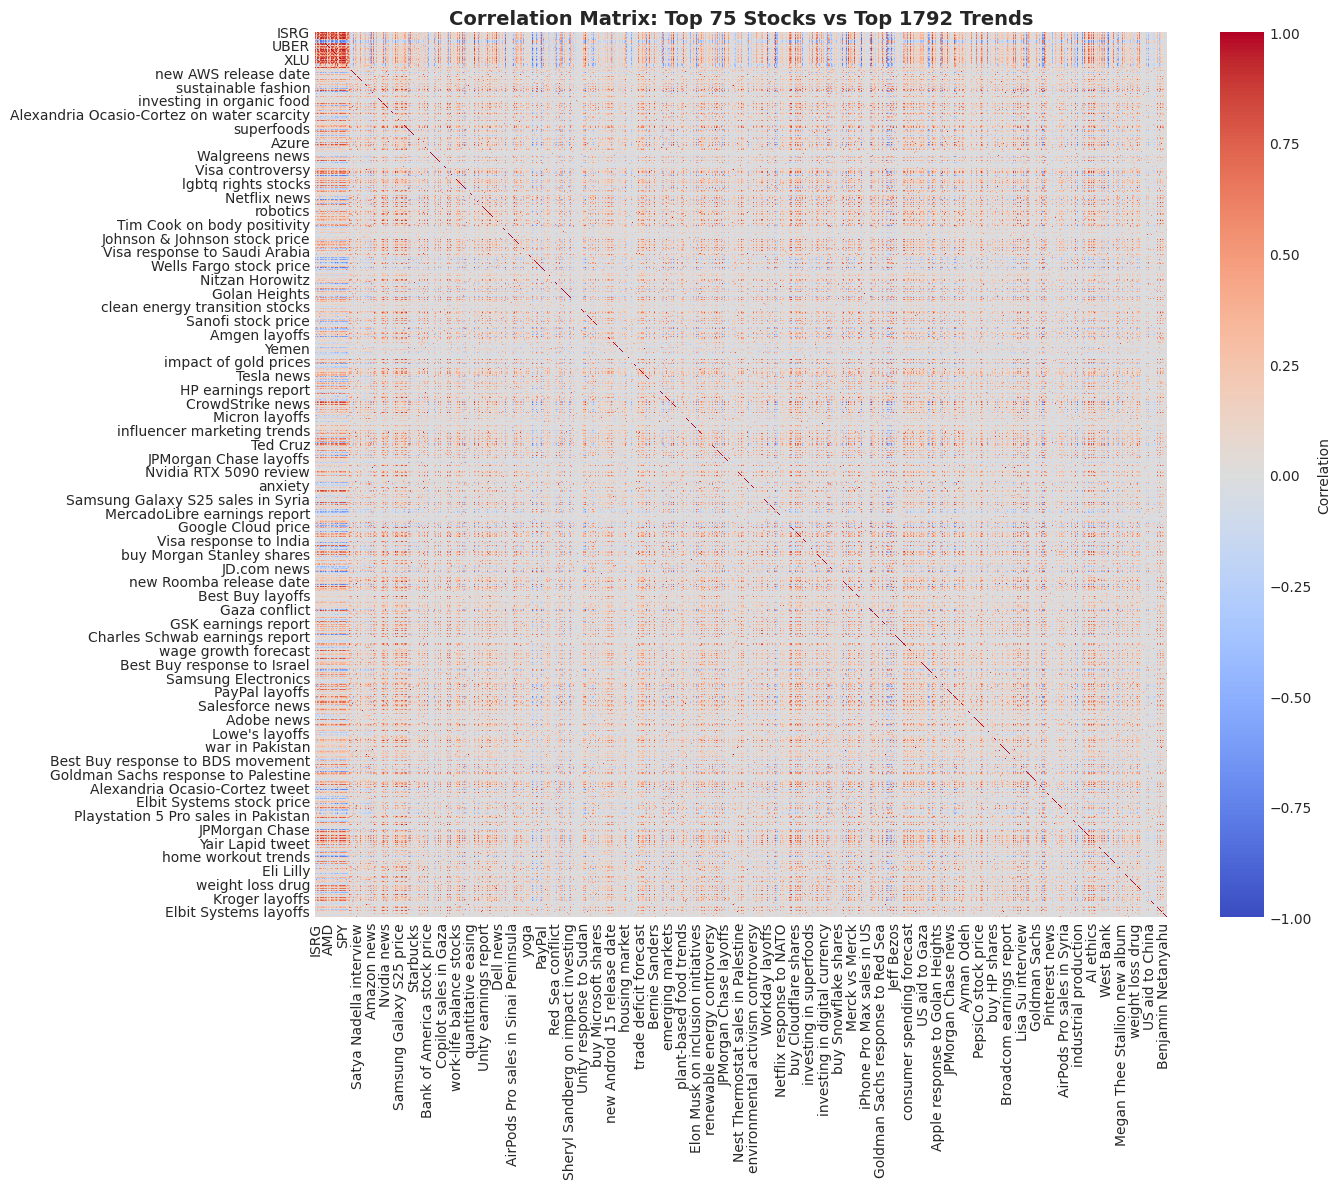


Strongest Correlations (excluding self-correlations):
--------------------------------------------------


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [54]:
# Find common dates between datasets
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=10000, sample_size_trends=10000)

Found 1796 common dates between datasets
   Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 75 stocks and top 100 trends...
Correlation matrix size: 175x175 (30625 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_75stocks_100trends.png'


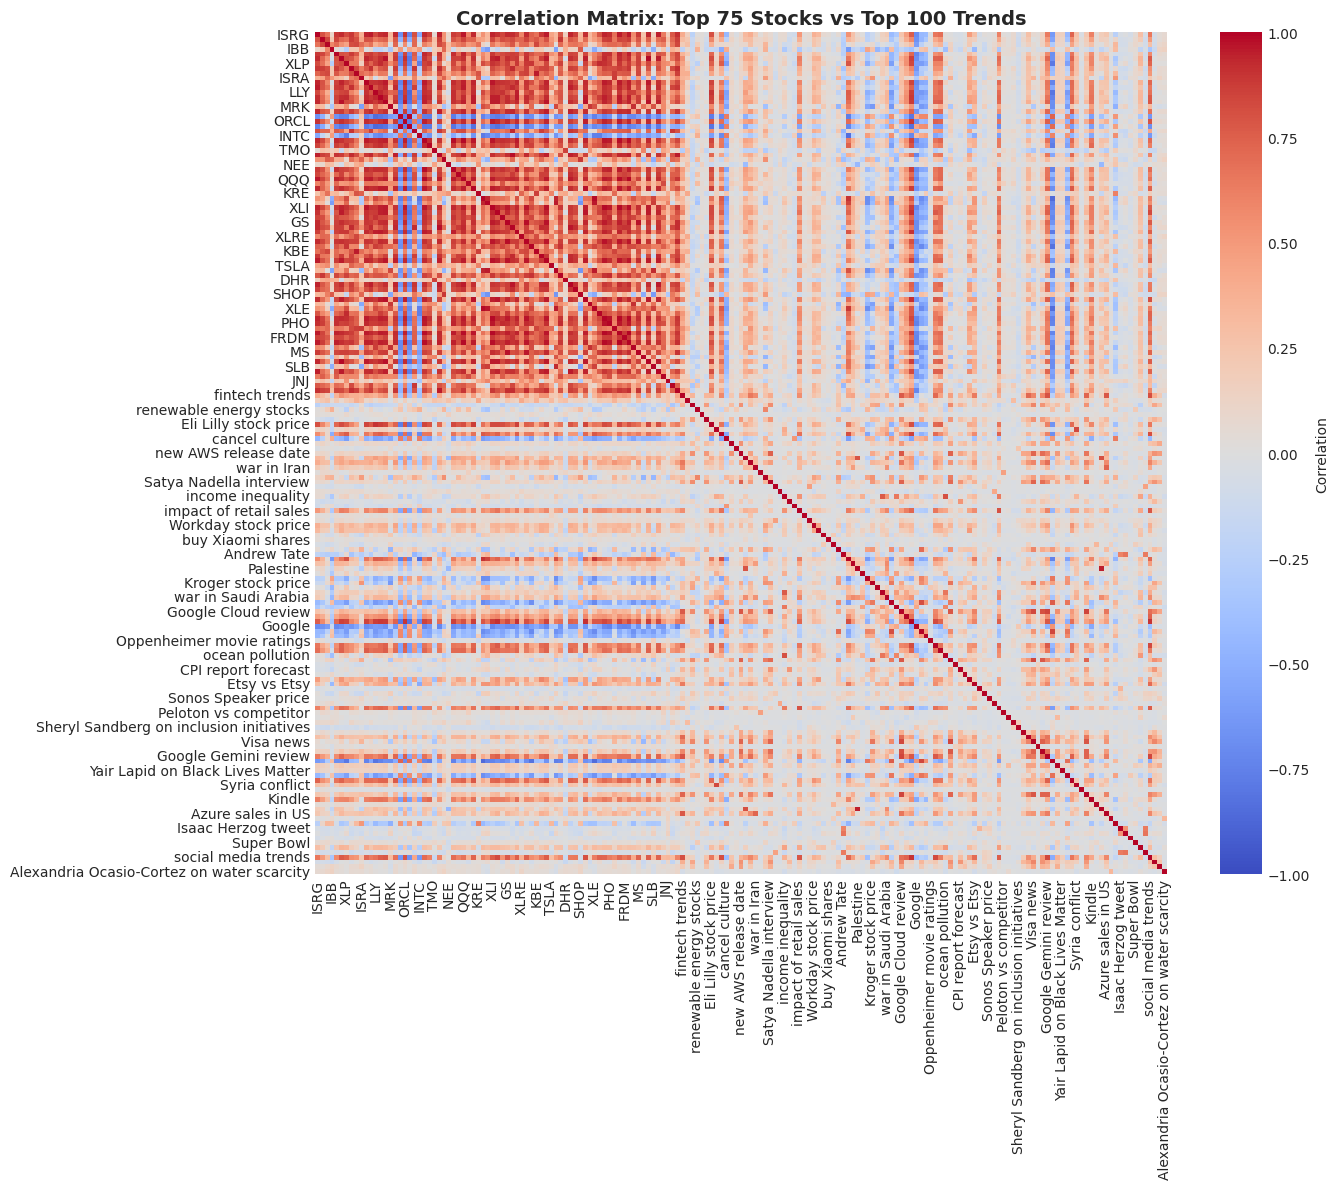


Strongest Correlations (excluding self-correlations):
--------------------------------------------------

Top 10 Stock-Trend Correlations:
 1. IBM             ↔ cybersecurity   : +0.914
 2. AVGO            ↔ cybersecurity   : +0.907
 3. PANW            ↔ cybersecurity   : +0.902
 4. XOM             ↔ Pinterest       : +0.900
 5. LLY             ↔ Eli Lilly stock price : +0.899
 6. ORCL            ↔ cybersecurity   : +0.897
 7. XLE             ↔ Pinterest       : +0.887
 8. COST            ↔ cybersecurity   : +0.886
 9. BKNG            ↔ cybersecurity   : +0.881
10. NVDA            ↔ Eli Lilly stock price : +0.872


In [51]:
# Find common dates between datasets
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=100, sample_size_trends=100)


Found 1796 common dates between datasets
   Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 50 stocks and top 50 trends...
Correlation matrix size: 100x100 (10000 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_50stocks_50trends.png'


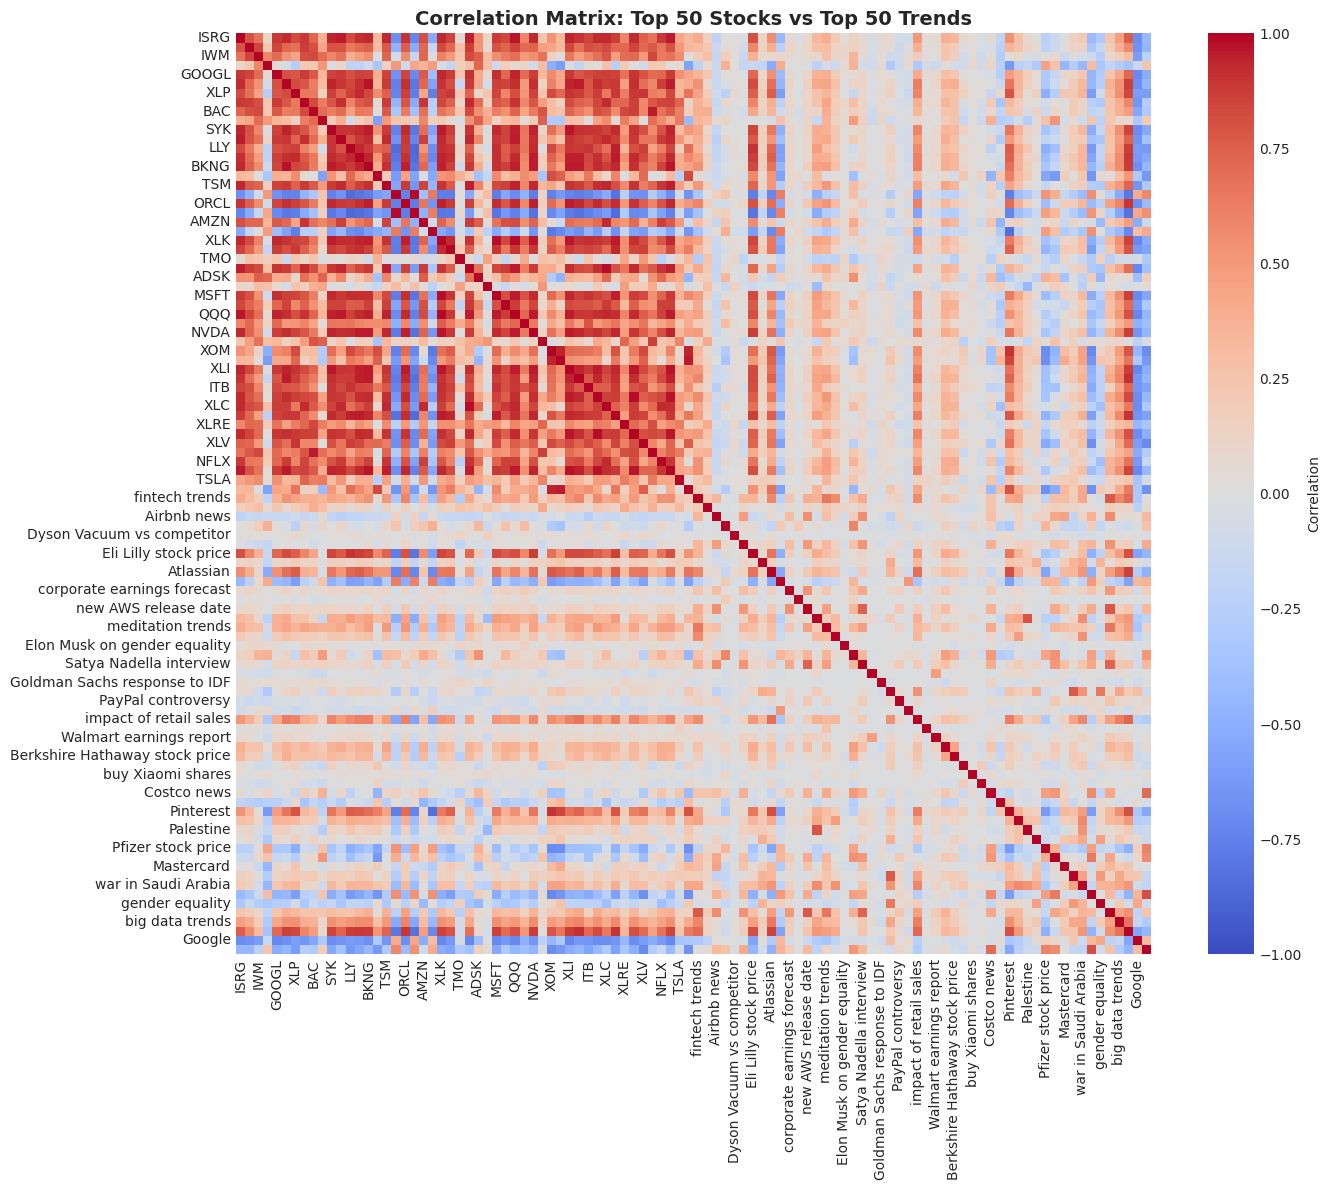


Strongest Correlations (excluding self-correlations):
--------------------------------------------------

Top 10 Stock-Trend Correlations:
 1. IBM             ↔ cybersecurity   : +0.914
 2. PANW            ↔ cybersecurity   : +0.902
 3. XOM             ↔ Pinterest       : +0.900
 4. LLY             ↔ Eli Lilly stock price : +0.899
 5. ORCL            ↔ cybersecurity   : +0.897
 6. COST            ↔ cybersecurity   : +0.886
 7. BKNG            ↔ cybersecurity   : +0.881
 8. NVDA            ↔ Eli Lilly stock price : +0.872
 9. XLI             ↔ cybersecurity   : +0.871
10. LLY             ↔ cybersecurity   : +0.871


In [52]:
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=50, sample_size_trends=50)

Found 1796 common dates between datasets
   Date range: 2020-08-27 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 10 stocks and top 10 trends...
Correlation matrix size: 20x20 (400 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_10stocks_10trends.png'


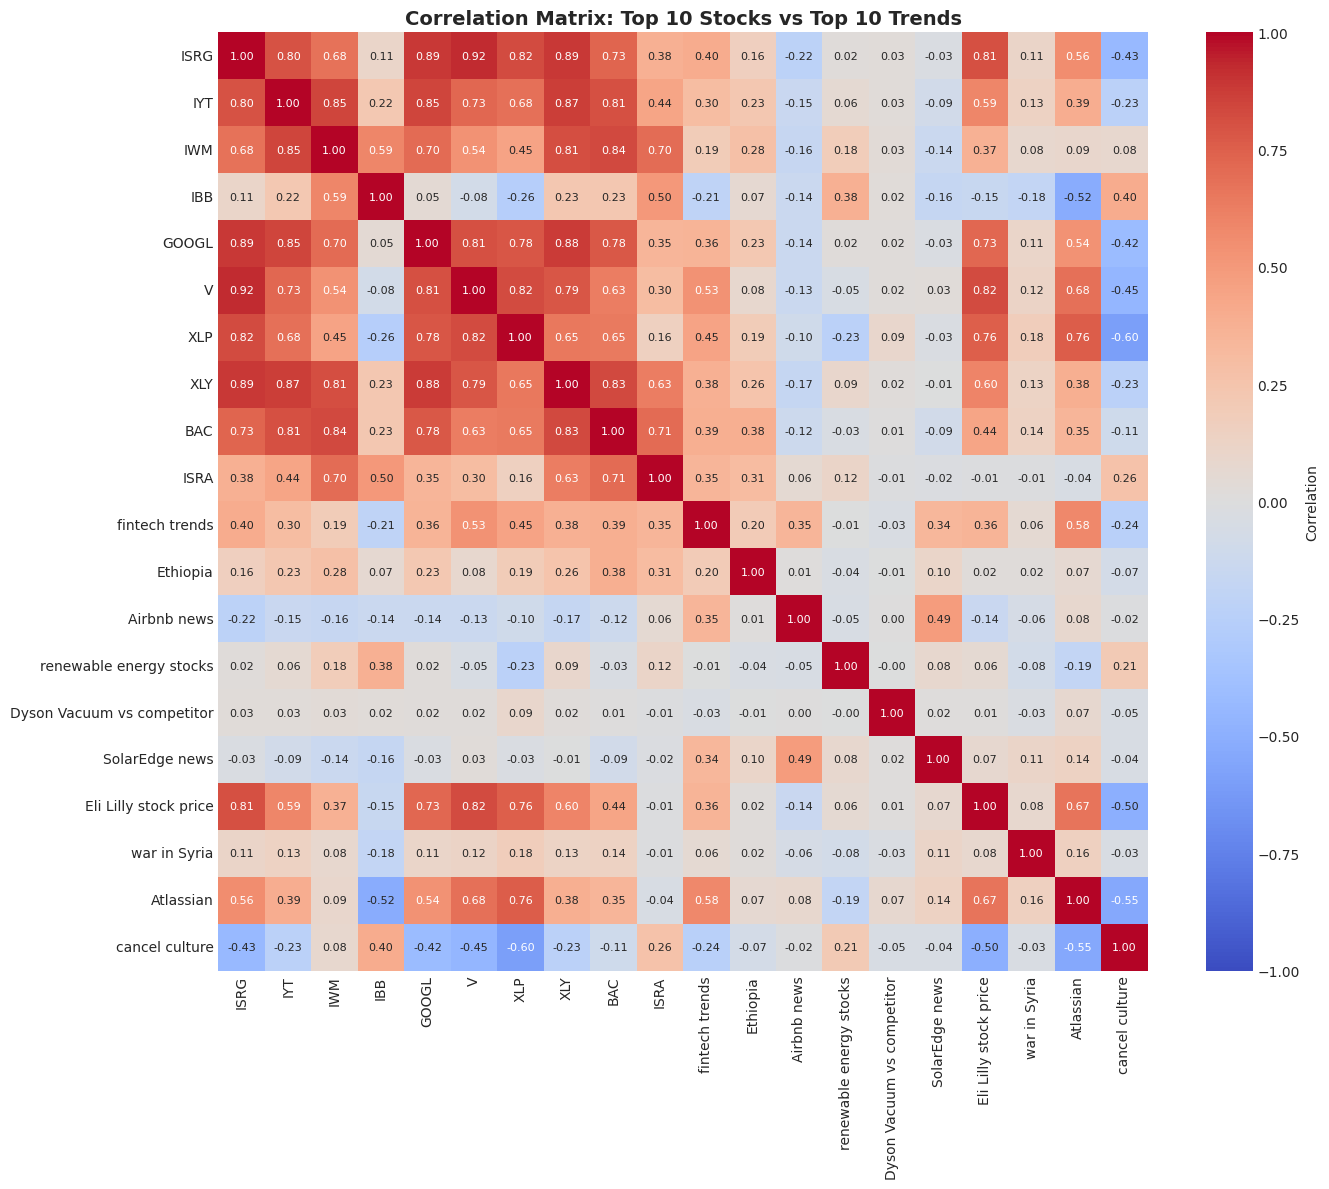


Strongest Correlations (excluding self-correlations):
--------------------------------------------------

Top 10 Stock-Trend Correlations:
 1. V               ↔ Eli Lilly stock price : +0.821
 2. ISRG            ↔ Eli Lilly stock price : +0.811
 3. XLP             ↔ Atlassian       : +0.759
 4. XLP             ↔ Eli Lilly stock price : +0.756
 5. GOOGL           ↔ Eli Lilly stock price : +0.726
 6. V               ↔ Atlassian       : +0.682
 7. XLP             ↔ cancel culture  : -0.600
 8. XLY             ↔ Eli Lilly stock price : +0.597
 9. IYT             ↔ Eli Lilly stock price : +0.586
10. ISRG            ↔ Atlassian       : +0.556


In [53]:
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=10, sample_size_trends=10)

### Time Series Analysis

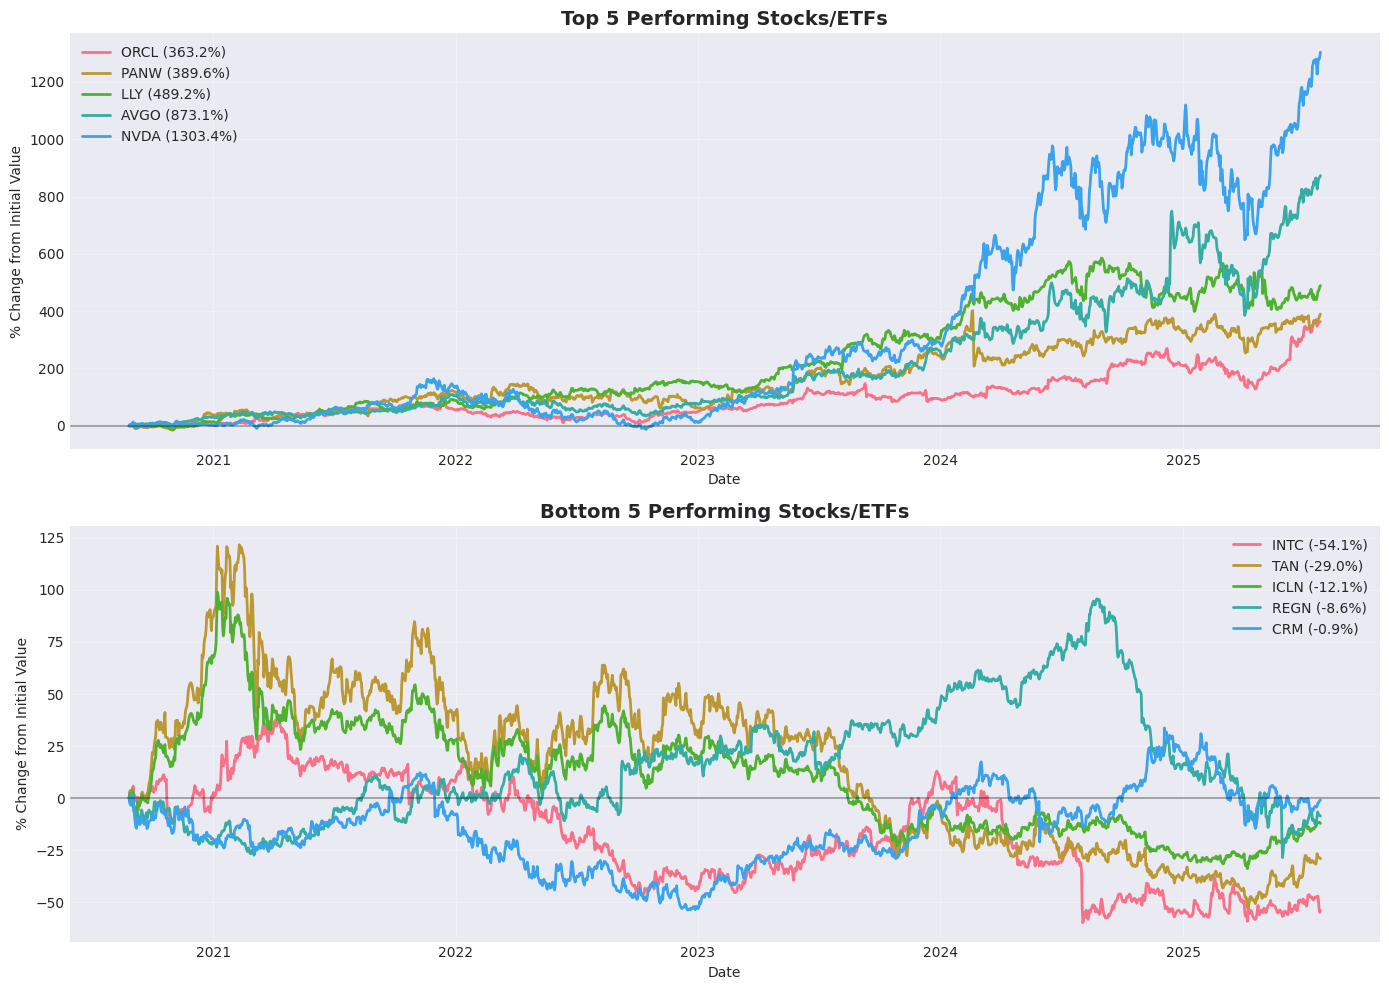

In [40]:
# Plot top performing stocks and most popular trends
if df_prices_normalized is not None:
    # Find top gainers and losers
    final_changes = df_prices_normalized.iloc[-1].sort_values()
    top_gainers = final_changes.tail(5).index
    top_losers = final_changes.head(5).index

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot top gainers
    for stock in top_gainers:
        axes[0].plot(df_prices_normalized.index, df_prices_normalized[stock],
                    label=f"{stock} ({final_changes[stock]:.1f}%)", linewidth=2)

    axes[0].set_title('Top 5 Performing Stocks/ETFs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('% Change from Initial Value')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Plot top losers
    for stock in top_losers:
        axes[1].plot(df_prices_normalized.index, df_prices_normalized[stock],
                    label=f"{stock} ({final_changes[stock]:.1f}%)", linewidth=2)

    axes[1].set_title('Bottom 5 Performing Stocks/ETFs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('% Change from Initial Value')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'top_bottom_performers.png', dpi=300, bbox_inches='tight')
    plt.show()

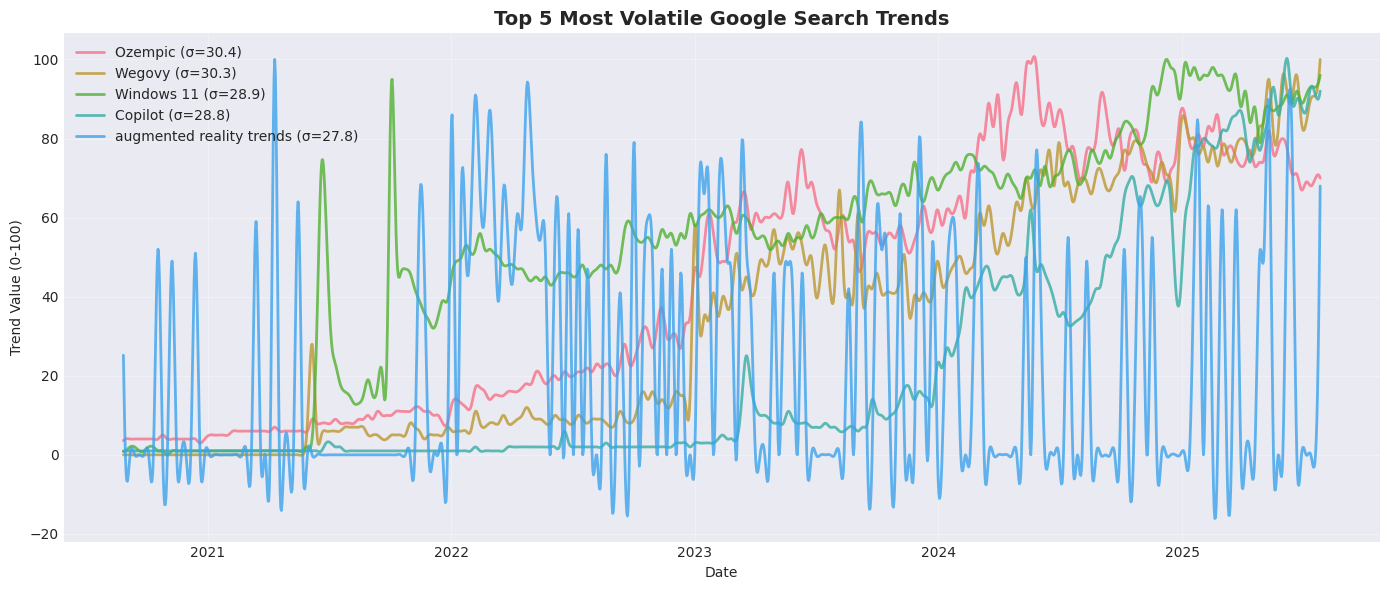

In [41]:
# Plot most volatile trends
if df_trends is not None:
    # Calculate volatility (standard deviation) for each trend
    trend_volatility = df_trends.std().sort_values(ascending=False)
    most_volatile = trend_volatility.head(5).index

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))

    for trend in most_volatile:
        ax.plot(df_trends.index, df_trends[trend],
                label=f"{trend} (σ={trend_volatility[trend]:.1f})",
                linewidth=2, alpha=0.8)

    ax.set_title('Top 5 Most Volatile Google Search Trends', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Trend Value (0-100)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'volatile_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

### Summary Statistics

In [42]:
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

if df_prices_normalized is not None:
    print("\nSTOCK/ETF PERFORMANCE:")
    print("-" * 40)

    final_changes = df_prices_normalized.iloc[-1].sort_values()

    print(f"Total stocks/ETFs analyzed: {len(df_prices.columns)}")
    print(f"Date range: {df_prices.index[0].strftime('%Y-%m-%d')} to {df_prices.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of trading days: {len(df_prices.index)}")

    print(f"\nPerformance Overview:")
    print(f"\t* Best performer: {final_changes.index[-1]} ({final_changes.iloc[-1]:.2f}%)")
    print(f"\t* Worst performer: {final_changes.index[0]} ({final_changes.iloc[0]:.2f}%)")
    print(f"\t* Average change: {final_changes.mean():.2f}%")
    print(f"\t* Median change: {final_changes.median():.2f}%")
    print(f"\t* Positive performers: {(final_changes > 0).sum()} ({(final_changes > 0).sum()/len(final_changes)*100:.1f}%)")
    print(f"\t* Negative performers: {(final_changes < 0).sum()} ({(final_changes < 0).sum()/len(final_changes)*100:.1f}%)")

if df_trends is not None:
    print("\nGOOGLE TRENDS:")
    print("-" * 40)

    print(f"Total search terms analyzed: {len(df_trends.columns)}")
    print(f"Date range: {df_trends.index[0].strftime('%Y-%m-%d')} to {df_trends.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of days: {len(df_trends.index)}")

    avg_trends = df_trends.mean().sort_values(ascending=False)

    print(f"\nTrend Popularity (Average):")
    print(f"\t* Most popular: {avg_trends.index[0]} ({avg_trends.iloc[0]:.1f})")
    print(f"\t* Least popular: {avg_trends.index[-1]} ({avg_trends.iloc[-1]:.1f})")
    print(f"\t* Average trend value: {avg_trends.mean():.1f}")

    trend_volatility = df_trends.std().sort_values(ascending=False)
    print(f"\nTrend Volatility:")
    print(f"\t* Most volatile: {trend_volatility.index[0]} (σ={trend_volatility.iloc[0]:.1f})")
    print(f"\t* Most stable: {trend_volatility.index[-1]} (σ={trend_volatility.iloc[-1]:.1f})")

print("\n" + "=" * 60)
print("Analysis complete! All visualizations have been saved.")
print("=" * 60)

ANALYSIS SUMMARY

STOCK/ETF PERFORMANCE:
----------------------------------------
Total stocks/ETFs analyzed: 75
Date range: 2020-08-27 to 2025-07-27
Number of trading days: 1796

Performance Overview:
	* Best performer: NVDA (1303.40%)
	* Worst performer: INTC (-54.07%)
	* Average change: 134.82%
	* Median change: 96.84%
	* Positive performers: 70 (93.3%)
	* Negative performers: 5 (6.7%)

GOOGLE TRENDS:
----------------------------------------
Total search terms analyzed: 1792
Date range: 2020-08-27 to 2025-07-27
Number of days: 1796

Trend Popularity (Average):
	* Most popular: Adobe (80.1)
	* Least popular: ChatGPT-5 price (0.2)
	* Average trend value: 13.4

Trend Volatility:
	* Most volatile: Ozempic (σ=30.4)
	* Most stable: ChatGPT-5 price (σ=3.5)

Analysis complete! All visualizations have been saved.


### Export Processed Data

In [44]:
if df_prices_normalized is not None:
    df_prices_normalized.to_csv(PROCESSED_DATA / 'prices_normalized.csv')
    print("Normalized prices saved to 'prices_normalized.csv'")

if 'correlation_matrix' in locals():
    correlation_matrix.to_csv(PLOT_ROOT / 'correlation_matrix.csv')
    print("Correlation matrix saved to 'correlation_matrix.csv'")

Normalized prices saved to 'prices_normalized.csv'
Correlation matrix saved to 'correlation_matrix.csv'


### Possible Next Steps
#### 1. **Clustering Analysis**: Group stocks with similar performance patterns
#### 2. **Lead-Lag Analysis**: Investigate if certain trends predict stock movements
#### 3. **Seasonal Patterns**: Analyze monthly or quarterly patterns in both datasets
#### 4. **Anomaly Detection**: Identify unusual spikes or drops in prices/trends
#### 5. **Rolling Correlations**: See how correlations change over time
#### 6. **Sector Analysis**: Group stocks by sector and compare sector performance